# Homework 8 - Group 1: Sensitivity to Boundary Head Conditions
#### (Python notebook created by Amanda Triplett)

 - **Group 1**:  Modify the self check example to make it a steady state model and then explore the sensitivity of the model to the boundary condition heads and the heads in the river (this would probably be best done with a loop).
  - First systematically vary the two boundary condition heads. You can vary both heads together as well as create gradients across the domain by having one side be higher.  Make sure you explore head ranges that make the aquifer confined and unconfined.
  - Then explore changing the head in the river again systematically varying it across a range of values.  
   - Use the river leakage outputs in the water balance file to calculate how the water exchanges between the river and the aquifer change as a function of head
   - Compare the impact of changing heads in the river to changing boundary condition heads on your results.



 <a name="I"></a>
### I. Import Packages and Create Model Object

In [57]:
#basic packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

 <a name="II"></a>
## II. Create packages that will remain static outside loop

### Variables for the dis package

In [58]:
#assign discretization variables
Lx = 1000.
Ly = 1000.
ztop = 0.
zbot = -50.
nlay = 1
nrow = 25
ncol = 25
dx = Lx/ncol
dy = Ly/nrow
dz = (ztop - zbot) / nlay

nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type


### Assign Cell Activity/Starting Heads and Attach BAS Package

In [59]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

#create strt as array of floats = 1m
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)


### Define Layer Properties and Attach LPF Package

- For simplicity, we assign uniform layer properties as a single value to be applied to every cell.

In [60]:
#define layer properties 
laytyp = 1
hk = 1.0 #m/d
vka = 1.0 #m/d
sy = 0.1 #1/m
ss = 1.e-4 #1/m

 <a name="III"></a>
 ## III. Creating and attaching packages, running the model in a loop

In [67]:
moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"

for scenario in range(0,10): #changing both head boundaries at the same time
    #create model object 
    modelname = "change_both_heads_" + str(scenario)
    print(modelname)
    m = flopy.modflow.Modflow(modelname, exe_name = moddir)
    
    #create flopy discretization object, length and time are meters (2) and days (4)
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)
    
    #BAS (Basic): assigns head boundaries
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
    
    #LPF (Layer Property Flow): assigns flow props between cells
    lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)
    
    #CHD package things
    #assign heads at start and end of stress period
    strt_head=[1,2,3,4,5,6,7,8,9,10]
    end_head=[1,2,3,4,5,6,7,8,9,10]
    #create list to hold stress period constant head boundary condition cells
    bound_sp1 = []
    #assign constant head boundary cells on the left and right boundaries
    for lay in range(nlay):
        for row in range(nrow):
            bound_sp1.append([lay,row,0,strt_head[scenario],end_head[scenario]]) #assigns all cells in 1st col
            bound_sp1.append([lay,row,ncol-1,strt_head[scenario],end_head[scenario]]) #assigns all cells in last col
    #create dictionary with stress period data
    chd_spd={0: bound_sp1}
    
    #create flopy CHD object, and attach to model
    chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)
    
    #DEFINE RIVERS
    #stress period 1 river cells
    riv_sp1 = [] #create list to store all river cells for stress period 1
    k_rivbott = 1 #river bottom hydraulic conductivity in m/d
    sed_thick = 1 #thickness of riverbed sediment in m
    cond = k_rivbott*(dy)*(dx)/(sed_thick) #river bed conductance in m^2/d
    r_stage = 1 #stage in river (stress period 1)
    r_bott = 0 #river bottom
    #assign river data to cells in central column
    for i in range(nrow):
        riv_sp1.append([0, i, ncol/2, r_stage, cond, r_bott])

    #create dictionary of stress period data
    riv_spd = {0: riv_sp1}
    
    #attach river package
    riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)
    
    #create and attach outputs by stress period (OC) package
    spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True) #OC (Output Control): Decides what outputs to save
    #Assign GW flow solver
    pcg = flopy.modflow.ModflowPcg(model=m) #PCG (Preconditioned Conjugate Gradient)

    
    #write MODFLOW input files
    m.write_input()
    
    # Run the model
    success, mfoutput = m.run_model(pause=False, report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')
        
for scenario in range(0,10):#varying left head, leaving the right constant to create gradients (sym. domain)
    #create model object 
    modelname = "change_left_head_" + str(scenario)
    print(modelname)
    #create model object 
    m = flopy.modflow.Modflow(modelname, exe_name = moddir)
    
    #create flopy discretization object, length and time are meters (2) and days (4)
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)
    
    #BAS (Basic): assigns head boundaries
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
    
    #LPF (Layer Property Flow): assigns flow props between cells
    lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)
    
    #CHD package things
    #assign heads at start and end of stress period
    strt_head=[1,2,3,4,5,6,7,8,9,10]
    end_head=[1,2,3,4,5,6,7,8,9,10]
    const_head_right = [5,5,5,5,5,5,5,5,5,5]
    #create list to hold stress period constant head boundary condition cells
    bound_sp1 = []
    #assign constant head boundary cells on the left and right boundaries
    for lay in range(nlay):
        for row in range(nrow):
            bound_sp1.append([lay,row,0,strt_head[scenario],end_head[scenario]]) #assigns all cells in 1st col
            bound_sp1.append([lay,row,ncol-1,const_head_right[scenario],const_head_right[scenario]]) #assigns all cells in last col
    #create dictionary with stress period data
    chd_spd={0: bound_sp1}
    
    #create flopy CHD object, and attach to model
    chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)
    
    #DEFINE RIVERS
    #stress period 1 river cells
    riv_sp1 = [] #create list to store all river cells for stress period 1
    k_rivbott = 1 #river bottom hydraulic conductivity in m/d
    sed_thick = 1 #thickness of riverbed sediment in m
    cond = k_rivbott*(dy)*(dx)/(sed_thick) #river bed conductance in m^2/d
    r_stage = 1 #stage in river (stress period 1)
    r_bott = 0 #river bottom
    #assign river data to cells in central column
    for i in range(nrow):
        riv_sp1.append([0, i, ncol/2, r_stage, cond, r_bott])

    #create dictionary of stress period data
    riv_spd = {0: riv_sp1}
    
    #attach river package
    riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)
    
    #create and attach outputs by stress period (OC) package
    spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True) #OC (Output Control): Decides what outputs to save
    #Assign GW flow solver
    pcg = flopy.modflow.ModflowPcg(model=m) #PCG (Preconditioned Conjugate Gradient)

    
    #write MODFLOW input files
    m.write_input()
    
    # Run the model
    success, mfoutput = m.run_model(pause=False, report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')

    
for scenario in range(0,10):#varying the river head
    #create model object 
    modelname = "change_river_head_" + str(scenario)
    print(modelname)
    #create model object 
    m = flopy.modflow.Modflow(modelname, exe_name = moddir)
    
    #create flopy discretization object, length and time are meters (2) and days (4)
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)
    
    #BAS (Basic): assigns head boundaries
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)
    
    #LPF (Layer Property Flow): assigns flow props between cells
    lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)
    
    #CHD package things
    #assign heads at start and end of stress period
    strt_head=[5,5,5,5,5,5,5,5,5,5]
    end_head=[5,5,5,5,5,5,5,5,5,5]
    #create list to hold stress period constant head boundary condition cells
    bound_sp1 = []
    #assign constant head boundary cells on the left and right boundaries
    for lay in range(nlay):
        for row in range(nrow):
            bound_sp1.append([lay,row,0,strt_head[scenario],end_head[scenario]]) #assigns all cells in 1st col
            bound_sp1.append([lay,row,ncol-1,strt_head[scenario],end_head[scenario]]) #assigns all cells in last col
    #create dictionary with stress period data
    chd_spd={0: bound_sp1}
    
    #create flopy CHD object, and attach to model
    chd = flopy.modflow.ModflowChd(model=m, stress_period_data=chd_spd)
    
    #DEFINE RIVERS
    #stress period 1 river cells
    riv_sp1 = [] #create list to store all river cells for stress period 1
    k_rivbott = 1 #river bottom hydraulic conductivity in m/d
    sed_thick = 1 #thickness of riverbed sediment in m
    cond = k_rivbott*(dy)*(dx)/(sed_thick) #river bed conductance in m^2/d
    r_stage = [1,2,3,4,5,6,7,8,9,10] #stage in river (stress period 1)
    r_bott = 0 #river bottom
    #assign river data to cells in central column
    for i in range(nrow):
        riv_sp1.append([0, i, ncol/2, r_stage[scenario], cond, r_bott])

    #create dictionary of stress period data
    riv_spd = {0: riv_sp1}
    
    #attach river package
    riv = flopy.modflow.ModflowRiv(model=m,stress_period_data = riv_spd, ipakcb=53)
    
    #create and attach outputs by stress period (OC) package
    spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True) #OC (Output Control): Decides what outputs to save
    #Assign GW flow solver
    pcg = flopy.modflow.ModflowPcg(model=m) #PCG (Preconditioned Conjugate Gradient)

    
    #write MODFLOW input files
    m.write_input()
    
    # Run the model
    success, mfoutput = m.run_model(pause=False, report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')



change_both_heads_0
FloPy is using the following  executable to run the model: /Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: change_both_heads_0.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/09  7:05:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/09  7:05:37
 Elapsed run time:  0.002 Seconds

  Normal termination of simulation
change_both_heads_1
FloPy is using the following  executable to run the model: /Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
       

FloPy is using the following  executable to run the model: /Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: change_left_head_2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/09  7:05:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/09  7:05:37
 Elapsed run time:  0.003 Seconds

  Normal termination of simulation
change_left_head_3
FloPy is using the following  executable to run the model: /Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             

FloPy is using the following  executable to run the model: /Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: change_river_head_4.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/09  7:05:37

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/09  7:05:37
 Elapsed run time:  0.003 Seconds

  Normal termination of simulation
change_river_head_5
FloPy is using the following  executable to run the model: /Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                           

### Check CHD and RIV Boundary Conditions

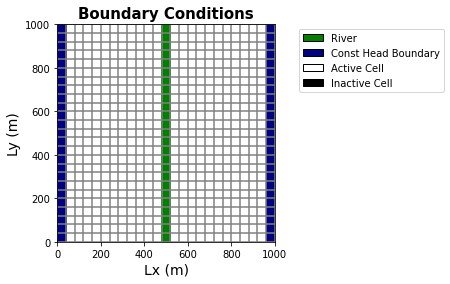

In [68]:
#CHECK BOUNDARY CONDITIONS
#use flopy to plot grid, ibound, rivers, and general head boundaries
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
riv_plot = modelmap.plot_bc(ftype='RIV')
chd_plot = modelmap.plot_bc(ftype='CHD')
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                   mp.patches.Patch(color='navy',label='Const Head Boundary',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.8,1.0))
plt.show(modelmap)

<a name="X"></a>
### X. Extract Head and Flow Data 

In [69]:
#extract binary data from head file
#times = [perlen[0],perlen[0]+perlen[1],perlen[0]+perlen[1]+perlen[2]] #extract times at end of each stress period
head = {} 
frf = {} 
fff = {} 
#storage = {} #create dictionary to store storage at end of each stress period
consthead = {} 
leakage = {} 

head2 = {} 
frf2 = {} 
fff2 = {} 
consthead2 = {} 
leakage2 = {}

head3 = {} 
frf3 = {} 
fff3 = {} 
consthead3 = {} 
leakage3 = {}

#get data from python objects
for scenario in range(0,10): #iterate through times at end of each stress period
    modelname = "change_both_heads_" + str(scenario)
    headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
    budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
    times = headobj.get_times()  
    head['run%s'%(scenario)] = headobj.get_data(totim=times[0])  
    frf['run%s'%(scenario)] = budgobj.get_data(text='FLOW RIGHT FACE',totim=1.0) 
    fff['run%s'%(scenario)] = budgobj.get_data(text='FLOW FRONT FACE',totim=1.0) 
    #storage['run%s'%(scenario)] = budgobj.get_data(text='STORAGE',totim=1.0) 
    consthead['run%s'%(scenario)] = budgobj.get_data(text='CONSTANT HEAD',totim=1.0) 
    leakage['run%s'%(scenario)] = budgobj.get_data(text='RIVER LEAKAGE',totim=1.0) 
    
    modelname2 = "change_left_head_" + str(scenario)
    headobj2 = flopy.utils.binaryfile.HeadFile(modelname2+'.hds')
    budgobj2 = flopy.utils.binaryfile.CellBudgetFile(modelname2+'.cbc')
    times2 = headobj2.get_times()  
    head2['run%s'%(scenario)] = headobj2.get_data(totim=times2[0])  
    frf2['run%s'%(scenario)] = budgobj2.get_data(text='FLOW RIGHT FACE',totim=1.0) 
    fff2['run%s'%(scenario)] = budgobj2.get_data(text='FLOW FRONT FACE',totim=1.0) 
    #storage['run%s'%(scenario)] = budgobj.get_data(text='STORAGE',totim=1.0) 
    consthead2['run%s'%(scenario)] = budgobj2.get_data(text='CONSTANT HEAD',totim=1.0) 
    leakage2['run%s'%(scenario)] = budgobj2.get_data(text='RIVER LEAKAGE',totim=1.0)
    
    modelname3 = "change_river_head_" + str(scenario)
    headobj3 = flopy.utils.binaryfile.HeadFile(modelname3+'.hds')
    budgobj3 = flopy.utils.binaryfile.CellBudgetFile(modelname3+'.cbc')
    times3 = headobj3.get_times()  
    head3['run%s'%(scenario)] = headobj3.get_data(totim=times3[0])  
    frf3['run%s'%(scenario)] = budgobj3.get_data(text='FLOW RIGHT FACE',totim=1.0) 
    fff3['run%s'%(scenario)] = budgobj3.get_data(text='FLOW FRONT FACE',totim=1.0) 
    #storage['run%s'%(scenario)] = budgobj.get_data(text='STORAGE',totim=1.0) 
    consthead3['run%s'%(scenario)] = budgobj3.get_data(text='CONSTANT HEAD',totim=1.0) 
    leakage3['run%s'%(scenario)] = budgobj3.get_data(text='RIVER LEAKAGE',totim=1.0)



In [70]:
#print tests

#print(headobj)
#print(times)
#print(head)
#print(scenario)
#headobj.get_data(totim=times[0])
#print(leakage)
#print(head2)


<a name="XI"></a>
## XI. Plotting

## Leakage Plots

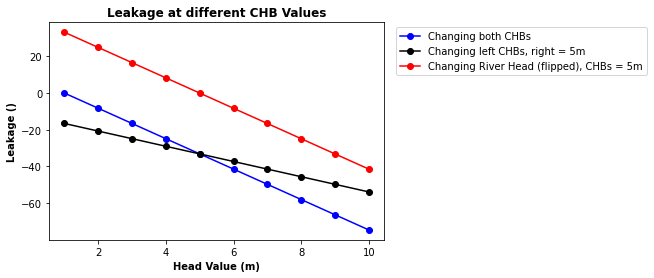

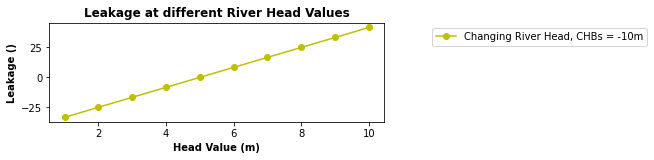

In [82]:
#make empty lists that will hold the leakage values for the river cells
#leakage values will be the same for every cell of the river because sym / homog
##domain and uniform stage height, K_bot, etc, so we only need to grab one to compare
y = [] #leakage list 1
y2 = [] #leakage list 2
y3 = [] #leakage list 3
y4 = [] #flip y-axis of scenario three to make easier to compare
x = [1,2,3,4,5,6,7,8,9,10] #head values for both CHBs in scenario 1
x2 = [1,2,3,4,5,6,7,8,9,10] #CHB of left boundary, righ tboundary constant @ -10
x3 = [1,2,3,4,5,6,7,8,9,10] #the head of the river, left and right CHB constant @-10
#Puts the values in a list
for scenario in range(0,10):

    temp = leakage['run%s'%(scenario)][0] #head matrix is flipped to display properly 
    y.append(temp.q[0])
    temp = leakage2['run%s'%(scenario)][0] #head matrix is flipped to display properly 
    y2.append(temp.q[0])
    temp = leakage3['run%s'%(scenario)][0] #head matrix is flipped to display properly 
    y3.append(temp.q[0])
y4 = [i * -1 for i in y3] 



#create plot
plt.subplot(1, 1, 1)
plt.title('Leakage at different CHB Values',fontweight='bold') 
plt.xlabel('Head Value (m)',fontweight='bold')
plt.ylabel('Leakage ()',fontweight='bold')
plt.plot(x,y, 'bo-',label='Changing both CHBs') 
plt.plot(x2,y2, 'ko-',label='Changing left CHBs, right = 5m') 
#plt.plot(x3,y3, 'yo-',label='Changing River Head, CHBs = 5m')
plt.plot(x3,y4, 'ro-',label='Changing River Head (flipped), CHBs = 5m')
#plt.plot(x3,y3, 'yo-') 
plt.legend(bbox_to_anchor=(1.8,1.0))
plt.show()

plt.subplot(2, 1, 1)
plt.title('Leakage at different River Head Values',fontweight='bold')
plt.xlabel('Head Value (m)',fontweight='bold')
plt.ylabel('Leakage ()',fontweight='bold')
plt.plot(x3,y3, 'yo-',label='Changing River Head, CHBs = -10m')
plt.legend(bbox_to_anchor=(1.8,1.0))

plt.show()



In [78]:
#print(y)
#print(y2)
#print(y3)
print(y4)

[]


### 3D Head Surface Plots

<strong> Note: </strong> Flopy takes cell indexing where the top left of the grid is the (0,0) cell index while the Length & Width units start at 0 in the lower left of the grid. This seems a little wierd, but it makes it easy to match up an array of cell by cell numbers to their respective locations on the grid when assigning properties or observing output data. Flopy's plotting capabilities automatically flip the resultant head data to display on its proper grid, however, for the 3d plots below, you'll see the function np.flipud() is used to flip the data array to plot in the same direction.

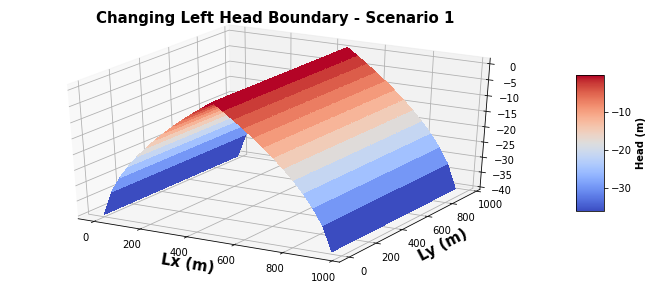

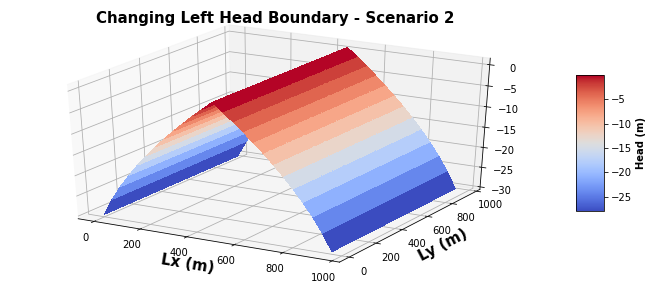

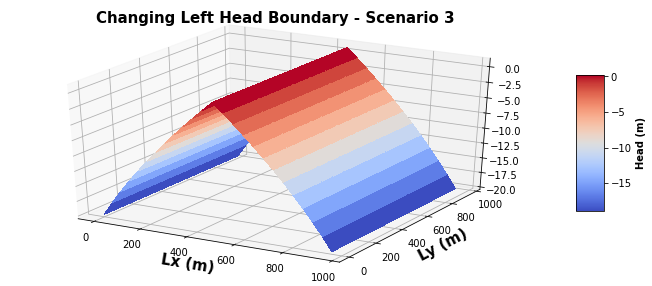

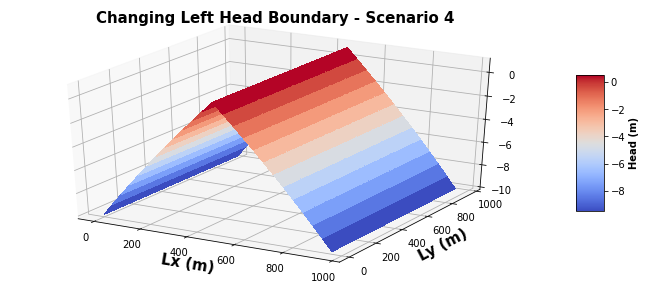

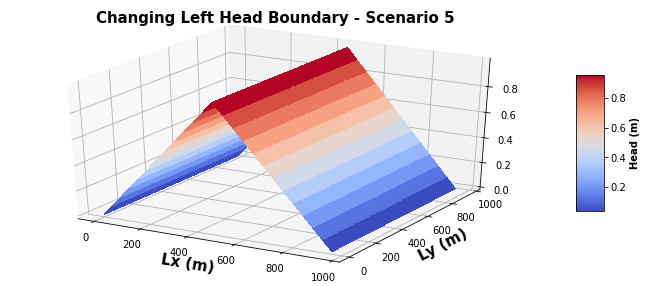

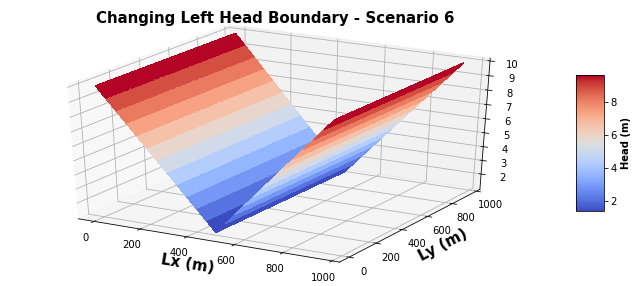

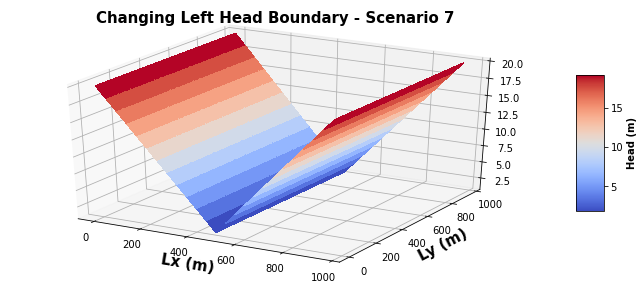

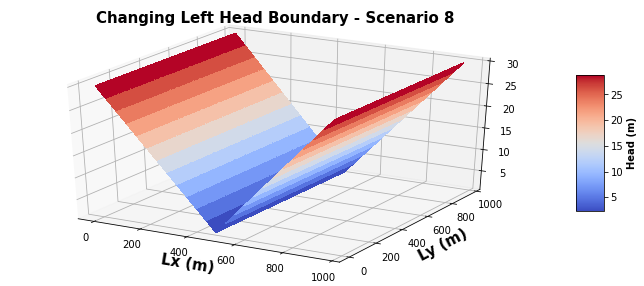

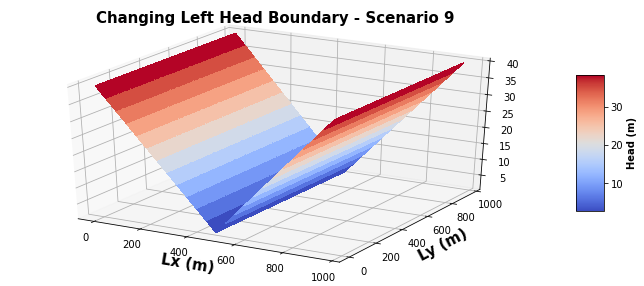

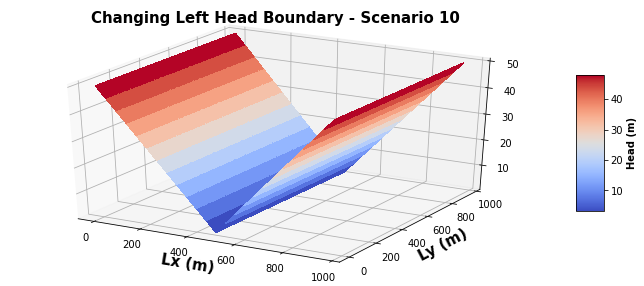

In [45]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)

#create a figure for every time
for scenario in range(0,10):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(head['run%s'%(scenario)][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Changing Left Head Boundary - Scenario %s'%(scenario+1), fontsize=15, fontweight='bold')
    plt.show(surf)

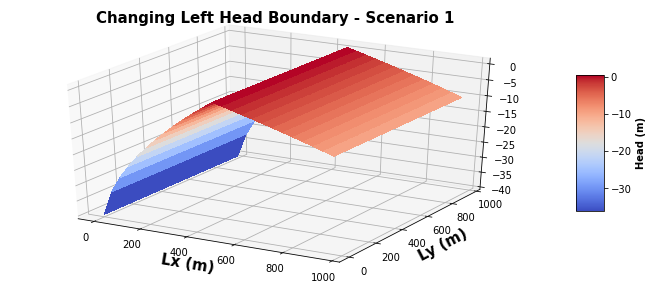

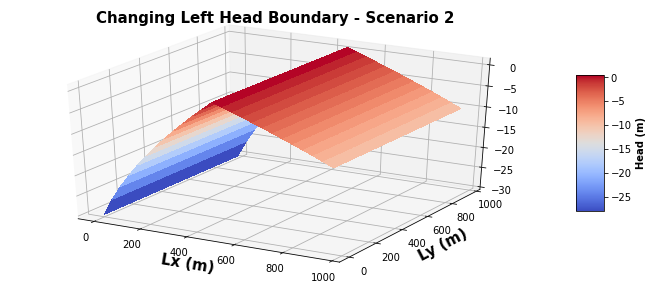

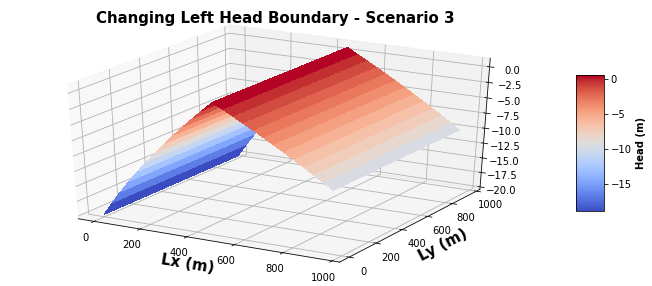

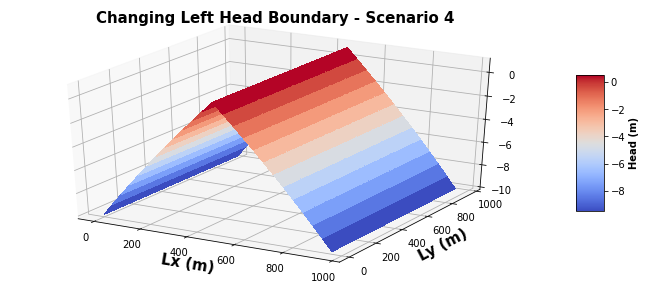

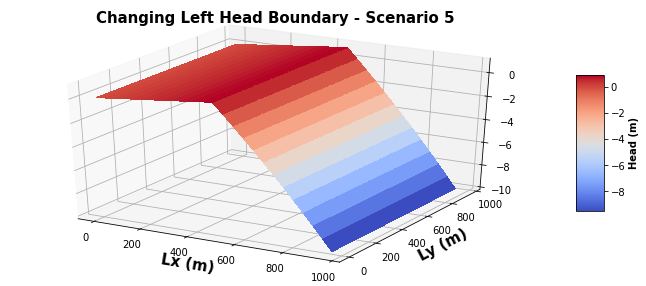

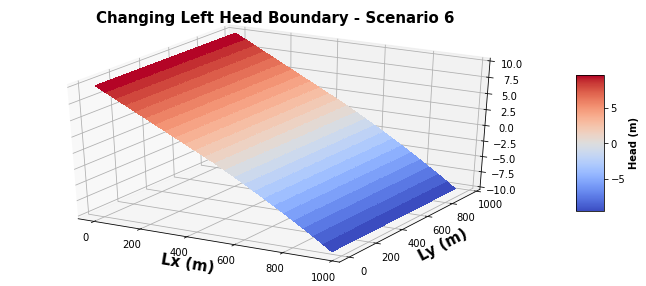

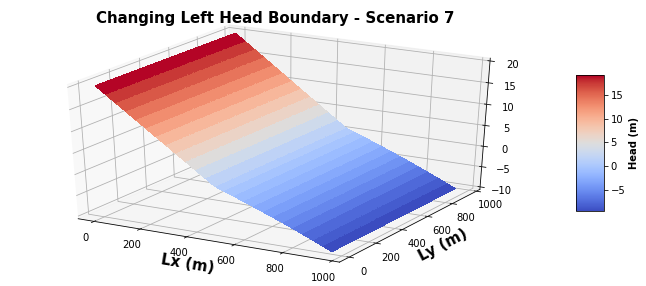

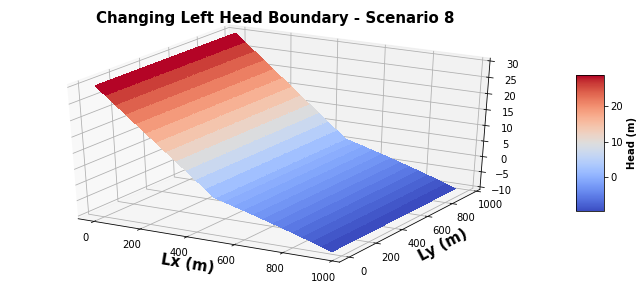

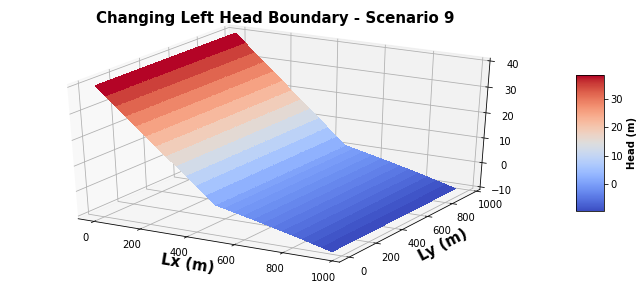

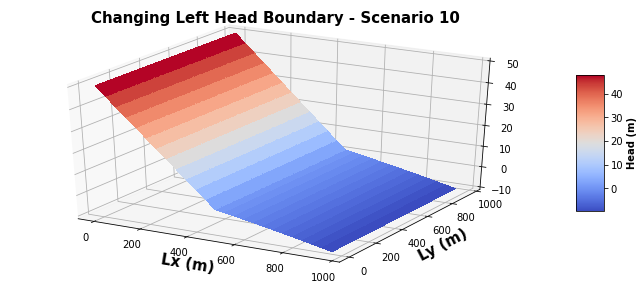

In [46]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)

#create a figure for every time
for scenario in range(0,10):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(head2['run%s'%(scenario)][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Changing Left Head Boundary - Scenario %s'%(scenario+1), fontsize=15, fontweight='bold')
    plt.show(surf)

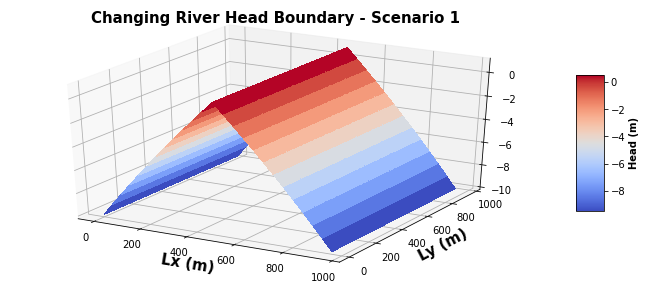

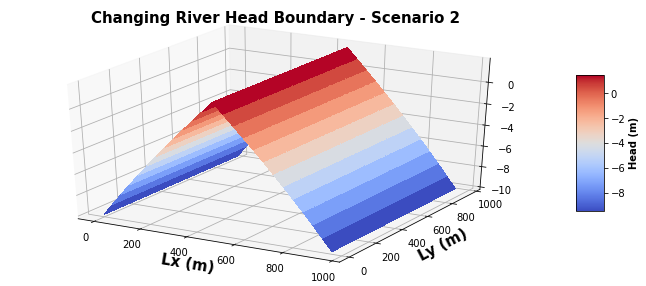

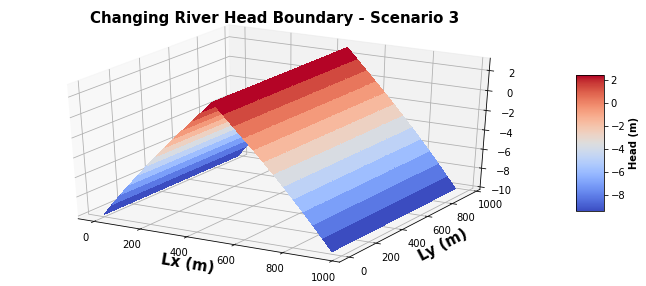

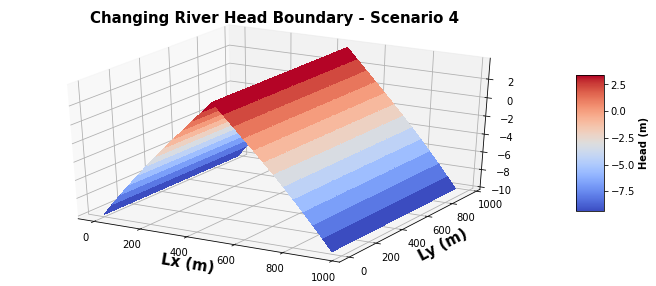

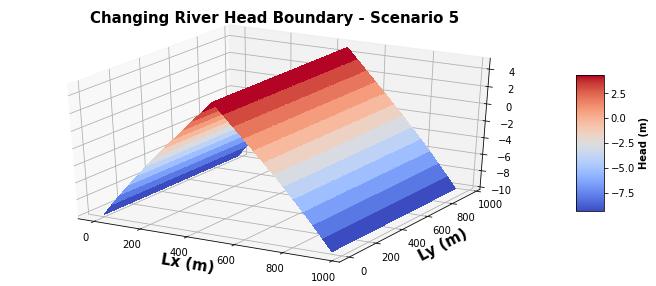

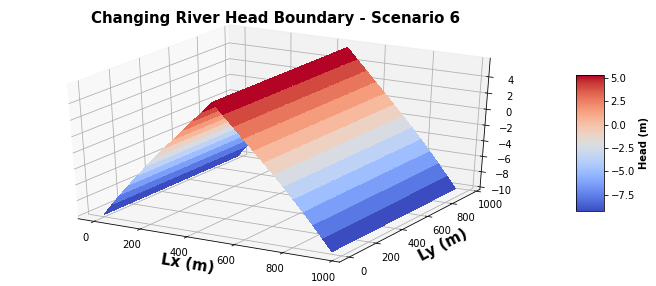

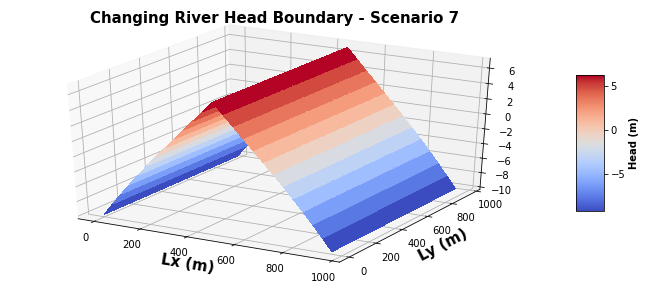

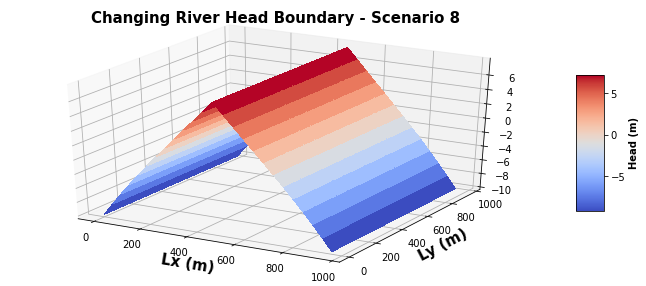

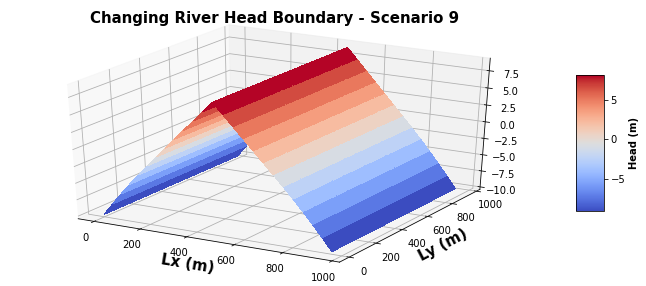

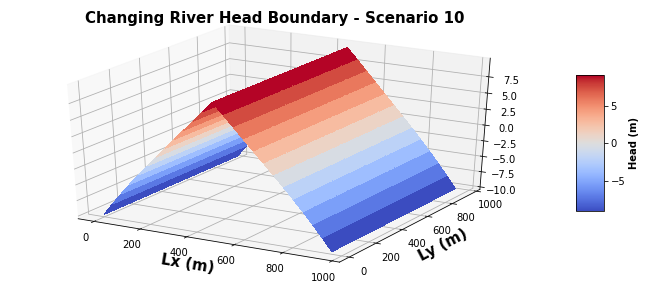

In [47]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)

#create a figure for every time
for scenario in range(0,10):
    #create 3d figure
    fig_3d = plt.figure(figsize=(12,5)) #create a figure instance
    ax = fig_3d.gca(projection='3d') #set an axes with 3d properties
    Z = np.flipud(head3['run%s'%(scenario)][0]) #head matrix is flipped to display properly 

    #create surface and labels
    surf = ax.plot_surface(X,Y,Z, cmap = plt.cm.coolwarm, linewidth=0, antialiased=False, label='head') #plot head surface
    fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold') #set colorbar
    ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
    ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
    ax.set_title('Changing River Head Boundary - Scenario %s'%(scenario+1), fontsize=15, fontweight='bold')
    plt.show(surf)

### Time Series Plot of Head at Single Cell

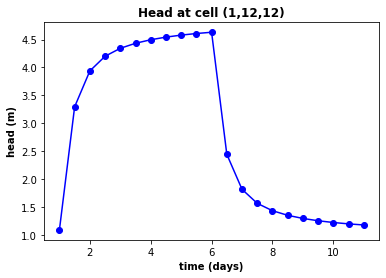

Time Series Head Data: 
 [[ 1.         1.0880829]
 [ 1.5        3.2954612]
 [ 2.         3.9382052]
 [ 2.5        4.2017574]
 [ 3.         4.343931 ]
 [ 3.5        4.4343276]
 [ 4.         4.497604 ]
 [ 4.5        4.5445633]
 [ 5.         4.5807242]
 [ 5.5        4.6092424]
 [ 6.         4.632088 ]
 [ 6.5        2.4432013]
 [ 7.         1.8155264]
 [ 7.5        1.56431  ]
 [ 8.         1.4322644]
 [ 8.5        1.3502005]
 [ 9.         1.2937887]
 [ 9.5        1.252489 ]
 [10.         1.2209972]
 [10.5        1.196332 ]
 [11.         1.1766671]]


In [33]:
#plot a time series at cell left of river
#get time series for cell
cell_id = (0, int(nrow/2) - 1, int(ncol/2) - 1) #specify which cell we're interested in (cell at center of model)
time_series = headobj.get_ts(cell_id) #get the time series using flopy

#create plot
plt.subplot(1, 1, 1)
plt.title('Head at cell ({0},{1},{2})'.format(cell_id[0] + 1, 
                                              cell_id[1] + 1, 
                                              cell_id[2] + 1),fontweight='bold') #create title with cell_id format
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series[:, 0], time_series[:, 1], 'bo-') #plot the time series with points at each record
plt.show()
print('Time Series Head Data: \n', time_series) #print the time series data